## Modified Slim

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde

######################
# ITER shape #
######################
eps = 0.32
kappa = 1.7
delta = 0.33
Amax = 10

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################

    N = num
    center = np.array([[0.0,0.0,0.0]])
    tau = np.linspace(0, 2 * np.pi, N)
    num_A = 20
    Arange = np.linspace(-Amax, Amax, num_A)
    # Define boundary of ellipse
    #x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
    #                eps * kappa * np.sin(tau), Arange]).T
    
    R_ellipse = np.outer(1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)),
                             np.ones(num_A)
                             )
    Z_ellipse = np.outer(eps * kappa * np.sin(tau),
                             np.ones(num_A)
                             )
    A_ellipse = np.outer(np.ones(N), Arange)
    x_ellipse = np.transpose(np.asarray([R_ellipse, Z_ellipse, A_ellipse]), [1, 2, 0])
    x_ellipse = x_ellipse.reshape(N * num_A, 3)

    print(x_ellipse.shape)
    uvals = np.zeros(len(x_ellipse)).reshape(len(x_ellipse), 1)
    return x_ellipse, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    A = x[:, 2:3]
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

spatial_domain = dde.geometry.Ellipse_A(eps, kappa, delta, Amax=Amax) 

x, u = gen_traindata(200)

n_test = 100
x_test,u_test = gen_traindata(n_test)
x_domain = spatial_domain.random_points(n_test)
x_test = np.concatenate((x_test, x_domain))
u_test = np.concatenate((u_test, np.zeros((n_test, 1))))

bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=2048,
    num_boundary=0,
    x_test=x_test,
    y_test=u_test,
    train_distribution="LHS"
)


Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term
(4000, 3)
(2000, 3)


In [2]:
data.train_x_bc.shape

(4000, 3)

Text(0.5, 0, '$u(r,z=0)$')

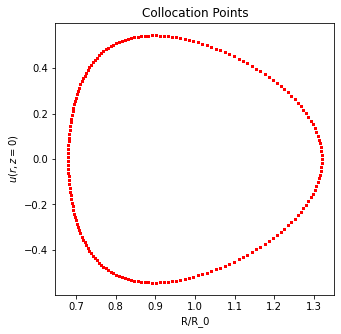

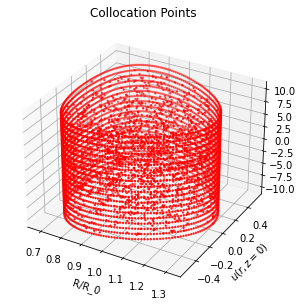

In [3]:
# Plot collocation points for visual check
# %matplotlib

fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

fig =plt.figure(2, figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(data.train_x[:,0], data.train_x[:,1], data.train_x[:,2], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

In [4]:
from utils.gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)

## Train Model

Compiling model...
Building feed-forward neural network...
'build' took 0.190584 s



/Users/alankaptanoglu/deepxde_copy/deepxde/maps/fnn.py:112: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 2.260875 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [4.56e+00, 6.73e-02]    [8.53e+00, 0.00e+00]    []  
10        [3.09e+00, 1.30e-01]    [6.47e+00, 0.00e+00]    []  
20        [3.19e+00, 1.18e-01]    [6.75e+00, 0.00e+00]    []  
30        [1.98e+00, 5.42e-02]    [3.57e+00, 0.00e+00]    []  
40        [8.31e-01, 2.12e-02]    [1.71e+00, 0.00e+00]    []  
50        [4.39e-01, 2.52e-02]    [1.24e+00, 0.00e+00]    []  
60        [2.23e-01, 3.19e-02]    [3.34e-01, 0.00e+00]    []  
70        [8.39e-02, 2.58e-02]    [2.72e-01, 0.00e+00]    []  
80        [5.61e-02, 1.43e-02]    [1.75e-01, 0.00e+00]    []  
90        [6.30e-02, 1.47e-02]    [1.16e-01, 0.00e+00]    []  
100       [2.33e-02, 9.43e-03]    [9.55e-02, 0.00e+00]    []  

Best model at step 100:
  train loss: 3.27e-02
  test loss: 9.55e-02
  test metric: []

'train' took 10.378127 s

Saving loss history to ./cefron/ITER/runs/network_

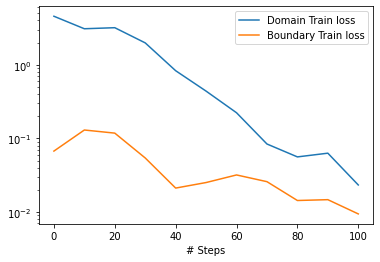

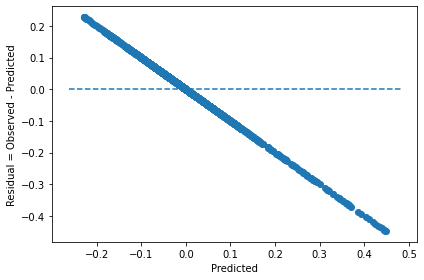

In [5]:
#[0.02,0.007,0.002,0.0007,0.0002]
import os
DATE = "10122022"
CONFIG = "ITER"
LR = 2e-2
DEPTH = 3
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([3] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,1]
  )
  loss_history, train_state = model.train(epochs=100, display_every = 10)
  dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')

#### After BFGS

Compiling model...
'compile' took 1.355641 s

Training model...

Step      Train loss              Test loss               Test metric
100       [2.33e-02, 9.43e-01]    [9.55e-02, 0.00e+00]    []  
110       [8.76e-02, 2.90e-01]                                
120       [8.29e-02, 8.48e-02]                                
130       [5.84e-02, 3.74e-02]                                
140       [3.64e-02, 3.17e-02]                                
150       [2.14e-02, 1.88e-02]                                
160       [1.21e-02, 1.55e-02]                                
170       [9.16e-03, 1.45e-02]                                
180       [6.66e-03, 1.02e-02]                                
190       [4.31e-03, 8.82e-03]                                
200       [3.39e-03, 7.92e-03]                                
210       [2.63e-03, 6.54e-03]                                
220       [2.15e-03, 6.14e-03]                                
230       [2.12e-03, 5.40e-03]                

1380      [1.77e-04, 2.56e-04]                                
1390      [1.65e-04, 2.59e-04]                                
1400      [1.71e-04, 2.39e-04]                                
1410      [1.67e-04, 2.33e-04]                                
1420      [1.62e-04, 2.31e-04]                                
1430      [1.59e-04, 2.23e-04]                                
1440      [1.57e-04, 2.21e-04]                                
1450      [1.60e-04, 2.14e-04]                                
1460      [1.62e-04, 2.08e-04]                                
1470      [1.65e-04, 2.01e-04]                                
1480      [1.67e-04, 1.98e-04]                                
1490      [1.66e-04, 1.93e-04]                                
1500      [1.68e-04, 1.82e-04]                                
1510      [1.65e-04, 1.75e-04]                                
1520      [1.60e-04, 1.73e-04]                                
1530      [1.57e-04, 1.67e-04]                         

2690      [4.11e-05, 1.88e-05]                                
2700      [4.08e-05, 1.88e-05]                                
2710      [4.00e-05, 1.87e-05]                                
2720      [3.95e-05, 1.87e-05]                                
2730      [3.90e-05, 1.86e-05]                                
2740      [3.87e-05, 1.87e-05]                                
2750      [3.84e-05, 1.88e-05]                                
2760      [3.80e-05, 1.88e-05]                                
2770      [3.77e-05, 1.87e-05]                                
2780      [3.72e-05, 1.85e-05]                                
2790      [3.66e-05, 1.86e-05]                                
2800      [3.59e-05, 1.88e-05]                                
2810      [3.55e-05, 1.89e-05]                                
2820      [3.51e-05, 1.89e-05]                                
2830      [3.47e-05, 1.88e-05]                                
2840      [3.37e-05, 1.83e-05]                         

4000      [1.58e-05, 6.52e-06]                                
4010      [1.57e-05, 6.47e-06]                                
4020      [1.55e-05, 6.45e-06]                                
4030      [1.55e-05, 6.40e-06]                                
4040      [1.54e-05, 6.37e-06]                                
4050      [1.52e-05, 6.42e-06]                                
4060      [1.50e-05, 6.45e-06]                                
4070      [1.48e-05, 6.50e-06]                                
4080      [1.47e-05, 6.51e-06]                                
4090      [1.46e-05, 6.50e-06]                                
4100      [1.45e-05, 6.50e-06]                                
4110      [1.44e-05, 6.53e-06]                                
4120      [1.42e-05, 6.57e-06]                                
4130      [1.40e-05, 6.60e-06]                                
4140      [1.39e-05, 6.66e-06]                                
4150      [1.38e-05, 6.64e-06]                         

5310      [8.21e-06, 3.74e-06]                                
5320      [8.21e-06, 3.72e-06]                                
5330      [8.19e-06, 3.72e-06]                                
5340      [8.19e-06, 3.71e-06]                                
5350      [8.15e-06, 3.71e-06]                                
5360      [8.11e-06, 3.68e-06]                                
5370      [8.03e-06, 3.65e-06]                                
5380      [8.02e-06, 3.62e-06]                                
5390      [7.98e-06, 3.61e-06]                                
5400      [7.94e-06, 3.59e-06]                                
5410      [7.87e-06, 3.59e-06]                                
5420      [7.77e-06, 3.63e-06]                                
5430      [7.71e-06, 3.64e-06]                                
5440      [7.69e-06, 3.63e-06]                                
5450      [7.68e-06, 3.62e-06]                                
5460      [7.64e-06, 3.62e-06]                         

6620      [4.47e-06, 2.74e-06]                                
6630      [4.46e-06, 2.73e-06]                                
6640      [4.44e-06, 2.71e-06]                                
6650      [4.45e-06, 2.68e-06]                                
6660      [4.41e-06, 2.69e-06]                                
6670      [4.38e-06, 2.70e-06]                                
6680      [4.37e-06, 2.68e-06]                                
6690      [4.38e-06, 2.64e-06]                                
6700      [4.36e-06, 2.63e-06]                                
6710      [4.33e-06, 2.63e-06]                                
6720      [4.31e-06, 2.62e-06]                                
6730      [4.28e-06, 2.64e-06]                                
6740      [4.24e-06, 2.63e-06]                                
6750      [4.20e-06, 2.64e-06]                                
6760      [4.15e-06, 2.66e-06]                                
6770      [4.15e-06, 2.66e-06]                         

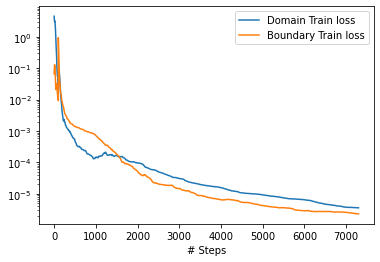

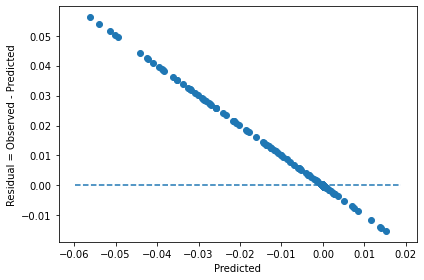

In [6]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1,100]
)
loss_history, train_state = model.train(epochs=1000, display_every = 10)
dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')


In [7]:
# Evaluation
from utils.utils import evaluate_A, relative_error_plot
ITER = GS_Linear(eps=eps, kappa=kappa, delta=delta)
xfull,yfull,A,psi_pred_full,psi_true_full,error=evaluate_A(ITER, model, Amax)
# X_test = spatial_domain.random_points(300)


(26010, 3)
(2000, 3)


[[-0.15042203 -0.14161007 -0.13349449 ... -0.13349449 -0.14161007
  -0.15042203]
 [-0.13664912 -0.12771796 -0.1195095  ... -0.1195095  -0.12771796
  -0.13664912]
 [-0.12397588 -0.11494159 -0.10665568 ... -0.10665568 -0.11494159
  -0.12397588]
 ...
 [ 0.5712613   0.54054968  0.50987409 ...  0.50987409  0.54054968
   0.5712613 ]
 [ 0.63058273  0.59746605  0.56447227 ...  0.56447227  0.59746605
   0.63058273]
 [ 0.69400602  0.65839635  0.62300047 ...  0.62300047  0.65839635
   0.69400602]] [[ 0.20141709  0.19128853  0.18190992 ...  0.18190992  0.19128853
   0.20141709]
 [ 0.18534725  0.17484266  0.1651225  ...  0.1651225   0.17484266
   0.18534725]
 [ 0.17049422  0.15962186  0.14956813 ...  0.14956813  0.15962186
   0.17049422]
 ...
 [-0.1974001  -0.19156351 -0.18486372 ... -0.18486372 -0.19156351
  -0.1974001 ]
 [-0.23248716 -0.22504229 -0.21679078 ... -0.21679078 -0.22504229
  -0.23248716]
 [-0.2705663  -0.26144049 -0.25156797 ... -0.25156797 -0.26144049
  -0.2705663 ]] 10


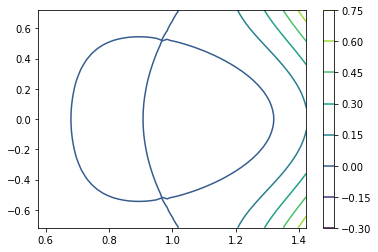

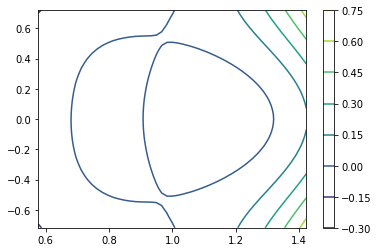

In [8]:
print(psi_true_full[:, :, 0], psi_true_full[:, :, -1], xfull.shape[2])
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_true_full[:, :, 0])
plt.colorbar()
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_pred_full[:, :, 0])
plt.colorbar()

0
2
4
6
8


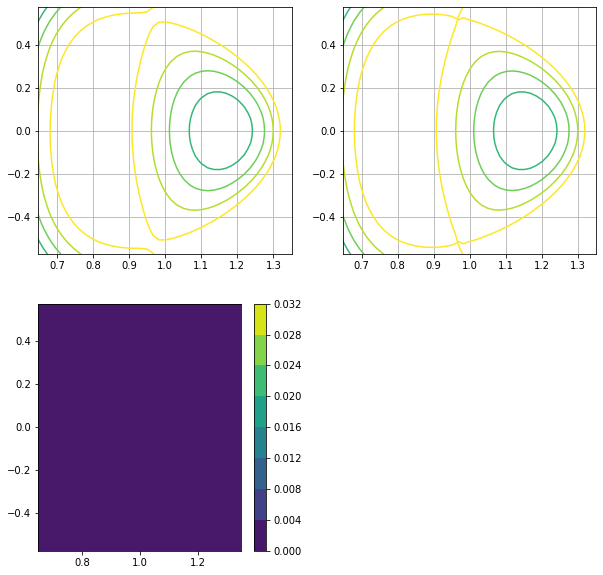

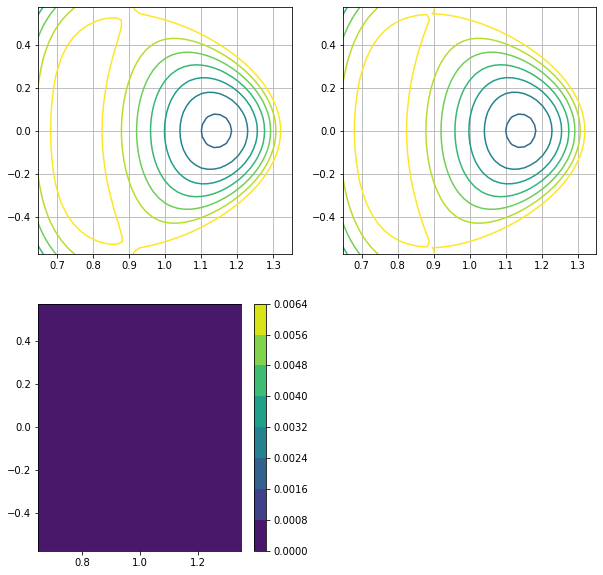

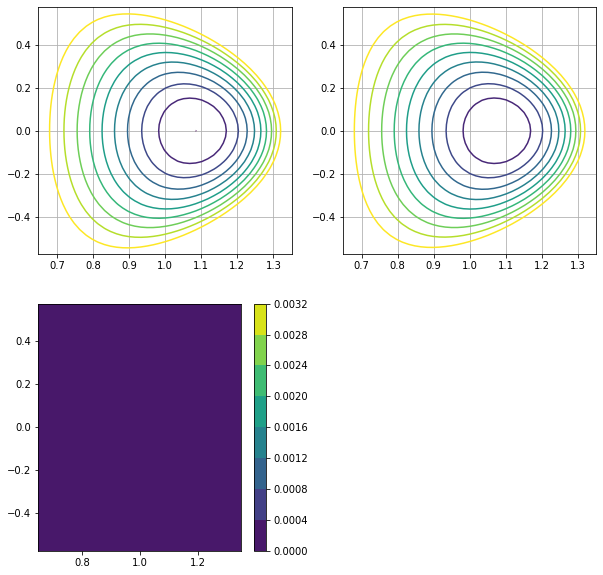

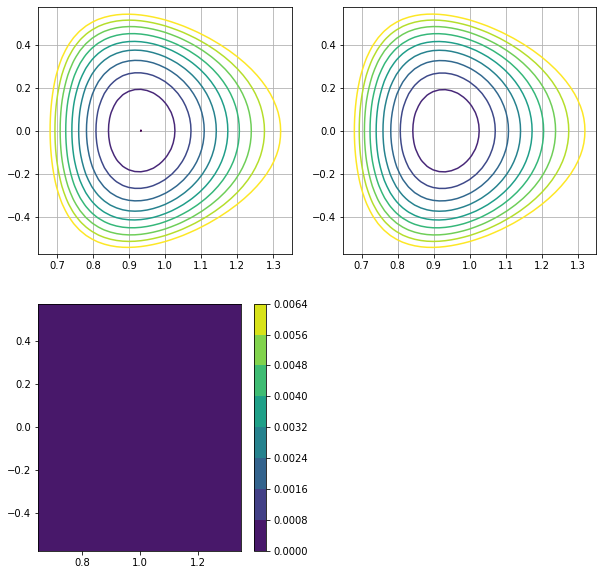

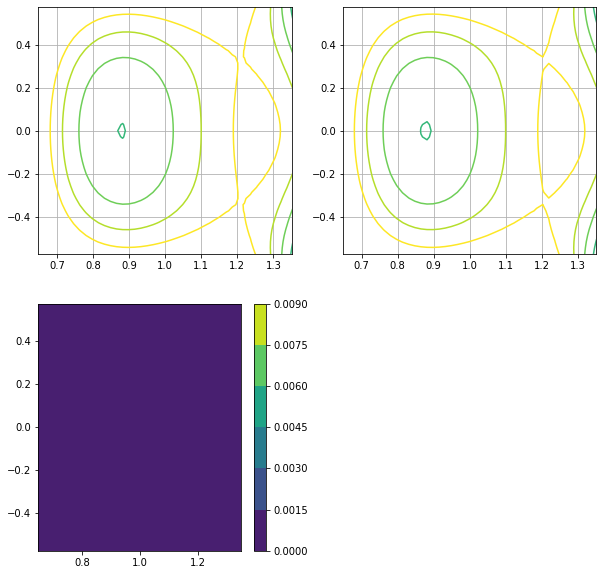

In [9]:
# Plotting Setup
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom

for i in range(0, xfull.shape[2], 2):
    print(i)
    plt.figure(i + 1, figsize=(10,10))

    levels = np.linspace(min(psi_true_full[:, :, i].reshape(-1)),0,10)
#     print(levels)
    
    plt.subplot(2, 2, 1)
    # Plot 1 - PINN Solution
    cp = plt.contour(xfull[:, :, i], yfull[:, :, i], psi_pred_full[:, :, i],levels=levels)
    # ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
    #plt.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
    #ax1.set_title('PINN Solution')
    #ax1.set_xlabel(r'$R/R_{0}$')
    #ax1.set_ylabel(r'$Z/R_{0}$')
    plt.grid(True)
    plt.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

    # Plot 2 - Analytic Solution
    plt.subplot(2, 2, 2)
    cp = plt.contour(xfull[:, :, i], yfull[:, :, i], psi_true_full[:, :, i],levels=levels)
    #plt.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
    #ax2.set_title('Analytical Solution')
    #ax2.set_xlabel(r'$R/R_{0}$')
    #ax2.set_ylabel(r'$Z/R_{0}$')
    plt.grid(True)
    plt.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

    # Plot 4 - Relative Error
    plt.subplot(2, 2, 3)
    cp = plt.contourf(xfull[:, :, i], yfull[:, :, i], error[:, :, i])  #,levels=levels)
    #fig.colorbar(cp,ax=ax3).formatter.set_powerlimits((0, 0))
    #ax2.set_title('Analytical Solution')
    #ax3.set_xlabel(r'$R/R_{0}$')
    #ax3.set_ylabel(r'$Z/R_{0}$')
    plt.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)
    plt.colorbar()

    fig.tight_layout()
    #plt.savefig(f'./cefron/{CONFIG}/runs/{RUN_NAME}/analysis_after_BFGS_A' + str(A[0, 0, i]) + ' .jpg')

